## Predictive Model for a given individual 

Now, we want to be able to predict, using a certain individual's self assessment, the probability that any partner of a date will want to see him again. and say 'yes' in our experiment.

For this, we get rid of wave 12 since those taking part in this wave were only allowed to say yes to a maximum of 50% of the people they spoke to. This skews the results in comparison to other waves.

For each individual, we will need his self assesment and the frequency at which his partner said 'yes'. It now seems clear that our model is one of linear regression, where our regressors are the attributes which we use to predict a value which corresponds to their chance of being accepted by the partner.

In [23]:
sdd[['iid','pid','match','gender','attr3_2','sinc3_2','fun3_2','amb3_2','intel3_2','wave']].dropna(axis = 0, how='any').shape

(7454, 10)

As wee see, of 8,378 rows, only 7,454 have no missing values, which amounts to 89% of values. We will use this data, without missing values, for our predictive model.

In [24]:
model_data = sdd[['iid','pid','match','gender','attr3_2','sinc3_2','fun3_2','amb3_2','intel3_2','wave']].dropna(axis = 0, how='any')
model_data = model_data[model_data['wave'] != 12] #drop wave 12 where the proportion of 'yes' was limited
model_data = model_data.drop(['wave'],axis=1)

In [25]:
model_data.head()

,iid,pid,match,gender,attr3_2,sinc3_2,fun3_2,amb3_2,intel3_2
0,1,11.0,0,0,6.0,7.0,7.0,6.0,8.0
1,1,12.0,0,0,6.0,7.0,7.0,6.0,8.0
2,1,13.0,1,0,6.0,7.0,7.0,6.0,8.0
3,1,14.0,1,0,6.0,7.0,7.0,6.0,8.0
4,1,15.0,1,0,6.0,7.0,7.0,6.0,8.0


In [26]:
#len(list(set(model_data['iid'].tolist())))
len(list(set(model_data['pid'].tolist())))

523

In [27]:
#We create a table with each subject's self-assessment
individual_grades = model_data.drop(['match','pid'],axis=1).groupby(['iid']).mean()
individual_grades = individual_grades.reset_index()

In [28]:
individual_grades.head()

,iid,gender,attr3_2,sinc3_2,fun3_2,amb3_2,intel3_2
0,1,0,6.0,7.0,7.0,6.0,8.0
1,2,0,7.0,6.0,9.0,4.0,8.0
2,4,0,6.0,8.0,8.0,6.0,7.0
3,5,0,6.0,6.0,9.0,9.0,9.0
4,6,0,5.0,8.0,8.0,3.0,9.0


Now we have a dataset that gives us, for each individual, his own self-assessment. 

We now compute the frequency of "yes" that each individual got. For that, we use column "pid" which gives the individual id of each subject's partner, and the average associated match i.e. the frequency of "yes" that this specific person received as a date partner

In [29]:
#for each partner, we compute the average match

average_matches = model_data[['pid','match']].astype(int)
average_matches = average_matches.groupby(['pid']).mean()
average_matches = average_matches.reset_index()
average_matches.shape

(523, 2)

In [30]:
average_matches.head()

,pid,match
0,1,0.428571
1,2,0.142857
2,3,0.000000
3,4,0.142857
4,5,0.142857


We now want to bind dataframes individual_grades and average_matches together so that we have a unique table in which, for each given individual, we have his self-assesment (regressors) and success rate. Thanks to this table we will be able to produce the predictive model we are looking for.

On SQL, this would be equivalent to "join on individual_grades.iid = average_matches.pid"

In [31]:
fit_data = individual_grades.merge(average_matches, how = 'inner', left_on = 'iid', right_on = 'pid')
fit_data = fit_data.drop(['iid','pid'],axis = 1)
fit_data.head()

,gender,attr3_2,sinc3_2,fun3_2,amb3_2,intel3_2,match
0,0,6.0,7.0,7.0,6.0,8.0,0.428571
1,0,7.0,6.0,9.0,4.0,8.0,0.142857
2,0,6.0,8.0,8.0,6.0,7.0,0.142857
3,0,6.0,6.0,9.0,9.0,9.0,0.142857
4,0,5.0,8.0,8.0,3.0,9.0,0.142857


We now have the data on which we are going to fit our regression model. However we must not forget that we have two different populations in our experiment; men and women and that we make the assumption they choose their partner differently. For this, we are going to split the data into two datasets, one for women and one for men

In [32]:
fit_data_male = fit_data[fit_data['gender'] == 1] #SHOULD BE 1
fit_data_male = fit_data_male.drop('gender', axis = 1)
fit_data_male['match'] = fit_data_male['match']*100

Let us now fit a linear regression model on the dataset for men

### Men's regression model

In [33]:
fit_data_male.head()

,attr3_2,sinc3_2,fun3_2,amb3_2,intel3_2,match
7,8.0,8.0,6.0,5.0,8.0,0.000000
8,3.0,7.0,8.0,2.0,7.0,42.857143
9,9.0,9.0,9.0,9.0,9.0,85.714286
10,7.0,7.0,7.0,9.0,9.0,28.571429
11,6.0,7.0,8.0,7.0,8.0,14.285714


In [34]:
X = fit_data_male.drop('match', axis = 1)
y = fit_data_male['match']

#Let us first split our dataset into a training dataset and a test dataset.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

In [35]:
#Now we train our linear regression model using the training data

from sklearn.linear_model import LinearRegression
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Analysis of results

In [36]:
#Let's now visualize the coefficients of the regressors of our model :

for idx, col_name in enumerate(X_train.columns): 
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

The coefficient for attr3_2 is 0.23272967328409294
The coefficient for sinc3_2 is -1.4827129349968502
The coefficient for fun3_2 is 2.840236923659491
The coefficient for amb3_2 is 0.12779991999411175
The coefficient for intel3_2 is 0.11910123728383323


The takeaway from this is : if you think you're funny, then a speed dating experiment should go well for you !

In [37]:
#Let's now visualize the intercept of our model :

intercept = regression_model.intercept_

print("The intercept for our model is {}".format(intercept))

The intercept for our model is 5.348886810906464


### Scoring men's model

Let us score the accuracy of our model using the $R^2$ statistic, defined as follows : $R^2 = 1 - \frac{RSS}{TSS}$. $TSS$ is the total variability of $y$, and $RSS = ||Y-f(x)||^2$ where $f(x)$ is the prediction of our model

In [38]:
print("The R^2 statistic for our model is",regression_model.score(X_test,y_test))

The R^2 statistic for our model is -0.263971309181


Let us now compute the sum of mean square errors. 

In [39]:
from sklearn.metrics import mean_squared_error

y_prediction = regression_model.predict(X_test)

model_men_MSE = mean_squared_error(y_prediction,y_test)
model_men_MSE

156.12599209203847

In [40]:
from math import sqrt

sqrt(model_men_MSE)

12.495038699101274

This calculation means that when we predict the probability for an individual to have their partner say "yes", we are off by roughly 14% on average.

### What is one looking for ?

However, what drives the choice of a person in their choice of a partner, based on how they judge him ? What makes a person decide whether they want to see somene again after spending just 4 minutes with that person ? Let's take a closer look ! 

In [41]:
model_choice = sdd[['iid','match','gender','attr','sinc','fun','amb','intel','shar','wave']].dropna(axis = 0, how='any')
model_choice.head()

,iid,match,gender,attr,sinc,fun,amb,intel,shar,wave
0,1,0,0,6.0,9.0,7.0,6.0,7.0,5.0,1
1,1,0,0,7.0,8.0,8.0,5.0,7.0,6.0,1
2,1,1,0,5.0,8.0,8.0,5.0,9.0,7.0,1
3,1,1,0,7.0,6.0,7.0,6.0,8.0,8.0,1
4,1,1,0,5.0,6.0,7.0,6.0,7.0,6.0,1


In [42]:
model_choice = model_choice[model_choice['wave'] != 12] #Get rid of wave 12
model_choice = model_choice.drop(['wave','iid'],axis=1) #Get rid of column 'wave' since we don't need it anymore

We want to know the importance of each attribute in a woman's choice. So we want a dataset where we have the grades men got from their female counterparts (so the gender = 0, i.e. the grades were given by a female) and whether or not the woman decided to go on with 'yes'

In [43]:
model_choice = model_choice[model_choice['gender'] == 0]
model_choice = model_choice.drop(['gender'],axis=1)
model_choice.head()

,match,attr,sinc,fun,amb,intel,shar
0,0,6.0,9.0,7.0,6.0,7.0,5.0
1,0,7.0,8.0,8.0,5.0,7.0,6.0
2,1,5.0,8.0,8.0,5.0,9.0,7.0
3,1,7.0,6.0,7.0,6.0,8.0,8.0
4,1,5.0,6.0,7.0,6.0,7.0,6.0


We want to fit a logistic regression model on this dataset, in order to predict the result of column 'match' depending on the 6 regressors.

In [44]:
X2 = model_choice.drop('match', axis = 1) 
y2 = model_choice['match']

#Let us first split our dataset into a training dataset and a test dataset.
from sklearn.model_selection import train_test_split

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.10)

In [45]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression()
logreg_model.fit(X2_train, y2_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
#Let's now visualize the coefficients of the regressors of our model :

for idx, col_name in enumerate(X2_train.columns): 
    print("The coefficient for {} is {}".format(col_name, logreg_model.coef_[0][idx]))

The coefficient for attr is 0.20442907042591307
The coefficient for sinc is -0.0272649785569835
The coefficient for fun is 0.2924883520928467
The coefficient for amb is -0.13463546995836181
The coefficient for intel is 0.036901114227434056
The coefficient for shar is 0.2184182183871814


Let us plot the coefficients of our logistic regression to see them better ! 

In [47]:
my_dict = {}
for idx, col_name in enumerate(X2_train.columns):
    my_dict[col_name] = logreg_model.coef_[0][idx]

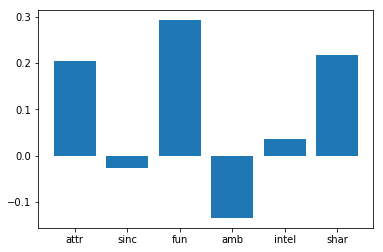

In [48]:
mpl.bar(range(len(my_dict)), list(my_dict.values()), align='center')
mpl.xticks(range(len(my_dict)), list(my_dict.keys()))
mpl.show()

As we can see, what matters most to women (at least, in a speed dating experiment) is whether her partner is funny, attractive and shares interests with her. Being perceived as ambitious, reduces the chances for a man of being liked by her partner.